In [11]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import time
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

### Загрузка данных

Files already downloaded and verified
Files already downloaded and verified
Метки классов: truck bird  horse ship  truck deer  deer  bird  ship  airplane horse bird  deer  cat   frog  cat   automobile deer  bird  dog   ship  dog   horse deer  frog  ship  bird  deer  automobile dog   ship  horse frog  truck truck dog   cat   cat   horse truck dog   cat   bird  bird  bird  ship  deer  bird  frog  cat  


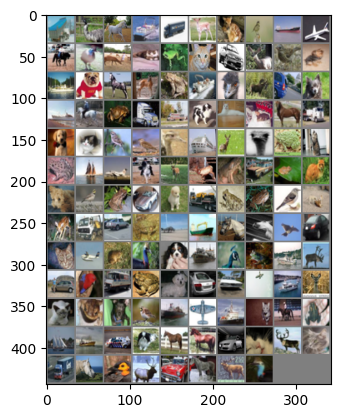

In [12]:
# Загрузка данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Функция для отображения изображений и меток классов
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Получение случайного пакета обучающих данных
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Отображение пакета изображений и меток
imshow(torchvision.utils.make_grid(images, nrow=10))
print('Метки классов:', ' '.join(f'{class_names[labels[j]]:5s}' for j in range(50)))

In [13]:
def modify_model(model, last_layers_only=True, device="cpu"):
    # Перемещаем модель на устройство
    work_model = model.to(device)

    if last_layers_only:
        # Обучение только последних слоев
        for param in work_model.parameters():
            param.requires_grad = False
        num_ftrs = work_model.fc.in_features
        work_model.fc = nn.Linear(num_ftrs, 10).to(device)  # 10 классов в CIFAR-10
    else:
        # Полное обучение сети
        num_ftrs = work_model.fc.in_features
        work_model.fc = nn.Linear(num_ftrs, 10).to(device)  # 10 классов в CIFAR-10
    return work_model

def train_and_evaluate(model, trainloader, testloader, experiment_name, device, last_layers_only=True, num_epochs=5, learning_rate=0.001, momentum=0.9):
    work_model = modify_model(model, last_layers_only, device)
    print(f"Эксперимент: {experiment_name}")

    # Определение функции потерь и оптимизатора
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(work_model.parameters(), lr=learning_rate, momentum=momentum)

    for epoch in range(num_epochs):
        start_time = time.time()

        # Обучение модели
        work_model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = work_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Тестирование модели
        work_model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = work_model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        end_time = time.time()
        epoch_time = end_time - start_time

        # Вывод информации о каждой эпохе
        print(f"Эпоха {epoch + 1}: Обучение - Потери: {running_loss / len(trainloader):.4f} Тестирование - Точность: {100 * correct / total:.2f}% Время выполнения: {epoch_time:.2f} сек\n")

    # Вывод финальной точности
    print("Обучение завершено.")
    print(f"Инициализация весов: Предобученные веса на ImageNet")
    print(f"Параметры обучения: SGD, learning rate = {learning_rate}, momentum = {momentum}, num_epochs = {num_epochs}")
    print(f"Финальная точность классификации на тестовой выборке: {100 * correct / total:.2f}%\n")
    return correct / total

In [14]:
# Список моделей для каждого эксперимента
models = [
    models.get_model('GoogLeNet', weights=models.GoogLeNet_Weights.IMAGENET1K_V1),
    models.get_model('resnet18', weights=models.ResNet18_Weights.IMAGENET1K_V1),
    models.get_model('shufflenet_v2_x0_5', weights=models.ShuffleNet_V2_X0_5_Weights.IMAGENET1K_V1),
    models.get_model('regnet_y_400mf', weights=models.RegNet_Y_400MF_Weights.IMAGENET1K_V1)
]
experiment_names = ["GoogLeNet", "resnet18", "shufflenet_v2_x0_5", "regnet_y_400mf"]
device="cuda" if torch.cuda.is_available() else "cpu"

for i in models:
  print(i)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

Эксперимент: GoogLeNet Full (epochs=5, lr=0.001)
Эпоха 1: Обучение - Потери: 1.7015 Тестирование - Точность: 57.37% Время выполнения: 27.31 сек

Эпоха 2: Обучение - Потери: 1.0606 Тестирование - Точность: 65.65% Время выполнения: 28.28 сек

Эпоха 3: Обучение - Потери: 0.8448 Тестирование - Точность: 69.14% Время выполнения: 27.32 сек

Эпоха 4: Обучение - Потери: 0.7133 Тестирование - Точность: 71.13% Время выполнения: 27.60 сек

Эпоха 5: Обучение - Потери: 0.6129 Тестирование - Точность: 72.22% Время выполнения: 27.59 сек

Обучение завершено.
Инициализация весов: Предобученные веса на ImageNet
Параметры обучения: SGD, learning rate = 0.001, momentum = 0.9, num_epochs = 5
Финальная точность классификации на тестовой выборке: 72.22%

Эксперимент: GoogLeNet Last Layers (epochs=10, lr=1e-05)
Эпоха 1: Обучение - Потери: 2.2579 Тестирование - Точность: 28.24% Время выполнения: 20.40 сек

Эпоха 2: Обучение - Потери: 1.9759 Тестирование - Точность: 47.23% Время выполнения: 21.82 сек

Эпоха 3: 

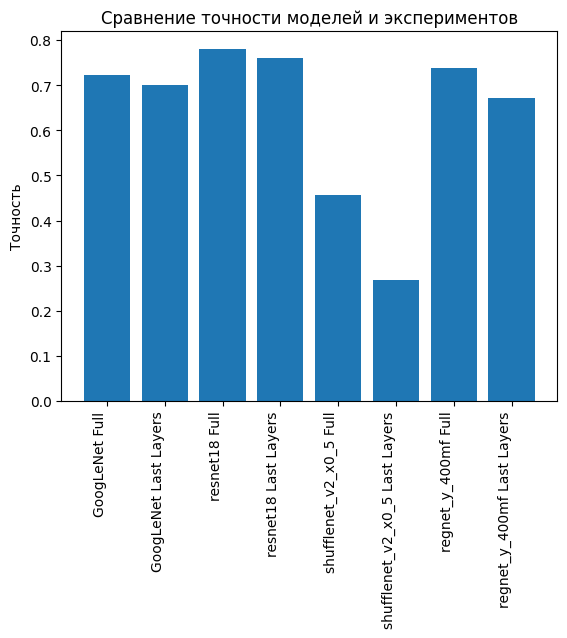

In [15]:
# Список конфигураций (last_layers_only, num_epochs, learning_rate)
configurations = [
    (False, 5, 0.001),
    (True, 10, 0.00001)
]

accuracies = []
exp_for_plot = []

for model, experiment_name in zip(models, experiment_names):
    for config in configurations:
        last_layers_only, num_epochs, learning_rate = config
        experiment = f"{experiment_name} {'Last Layers' if last_layers_only else 'Full'} (epochs={num_epochs}, lr={learning_rate})"
        accuracy = train_and_evaluate(model, trainloader, testloader, experiment, device=device,
                                      last_layers_only=last_layers_only, num_epochs=num_epochs, learning_rate=learning_rate)
        accuracies.append(accuracy)
        exp_for_plot.append(f"{experiment_name} {'Last Layers' if last_layers_only else 'Full'}")

# Построение столбчатой диаграммы
plt.bar(exp_for_plot, accuracies)
plt.ylabel('Точность')
plt.title('Сравнение точности моделей и экспериментов')
plt.xticks(rotation=90, ha='right')
plt.show()